In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
pattern_points = 5
moving_points = pattern_points * 10

In [3]:
columns = ["A", "B", "C"]

In [4]:
def custom_sequence(start, stop, num, repidx: int = 0):
    """Renturn non-linear increasing sequence values

    Non-linear increasing plots
    0. cumsum - flex increasing
    1. exponential - late increasing
    2. logarithmic - early increasing
    3. quadratic - smooth increasing, coefficient
    4. cubic - smooth increasing, coefficient
    """

    kind = 5
    intervals = np.linspace(0.1, 1.0, num)

    match repidx % kind:
        case 0:  # cumsum
            np.random.shuffle(intervals)
            sequence = np.cumsum(intervals)

        case 1:  # exponential
            sequence = np.exp(intervals)
            np.random.shuffle(intervals)
            sequence = sequence + intervals

        case 2:  # logarithimic
            sequence = np.log(intervals)
            np.random.shuffle(intervals)
            sequence = sequence + intervals

        case 3:  # quadratic, slop depend on coefficent (a,b,c)
            a, b, c = 1, -3, 2
            sequence = a * intervals**2 + b * intervals + c
            np.random.shuffle(intervals)
            sequence = sequence + intervals

        case _:  # cubic
            a, b, c, d = 1, -6, 11, -6
            sequence = a * intervals**3 + b * intervals**2 + c * intervals + d
            np.random.shuffle(intervals)
            sequence = sequence + intervals

    sequence = start + (stop - start) * (sequence - sequence.min()) / (sequence.max() - sequence.min())
    return sequence

In [5]:
def update_row_outer_iqr(df: pd.DataFrame, pattern_points: int):
    des = df.describe()
    des.loc["iqr"] = des.loc["75%", :] - des.loc["25%", :]

    sequences = dict()
    for col in columns:
        sequences[col] = custom_sequence(
            des.loc["50%", col], des.loc["75%", col] + des.loc["iqr", col] * 1.6, pattern_points, 0
        )

    def update_row_inner(row):
        nonlocal sequences
        repidx, patidx = divmod(row.name, pattern_points)
        if patidx == 0:
            for col in columns:
                sequences[col] = custom_sequence(
                    des.loc["50%", col], des.loc["75%", col] + des.loc["iqr", col] * 1.6, pattern_points, repidx
                )
        for col in columns:
            row[col] = np.float32(sequences[col][patidx])

        return row

    return update_row_inner

In [6]:
def update_row_outer_mvstd(df, pattern_points):
    des = df.describe()

    sequences = dict()
    for col in columns:
        sequences[col] = custom_sequence(
            des.loc["mean", "MAVG_" + col],
            des.loc["mean", "MAVG_" + col] + des.loc["std", "MSTD_" + col] * 3,
            pattern_points,
            0,
        )

    def update_row_inner(row):
        nonlocal sequences
        repidx, patidx = divmod(row.name, pattern_points)
        if patidx == 0:
            for col in columns:
                sequences[col] = custom_sequence(
                    des.loc["mean", "MAVG_" + col],
                    des.loc["mean", "MAVG_" + col] + des.loc["std", "MSTD_" + col] * 3,
                    pattern_points,
                    repidx,
                )
        for col in columns:
            row[col] = np.float32(sequences[col][patidx])

        return row

    return update_row_inner


def update_row_outer_std(df, pattern_points):
    des = df.describe()

    sequences = dict()
    for col in columns:
        sequences[col] = custom_sequence(
            des.loc["mean", col], des.loc["mean", col] + des.loc["std", col] * 3, pattern_points, 0
        )

    def update_row_inner(row):
        nonlocal sequences
        repidx, patidx = divmod(row.name, pattern_points)
        if patidx == 0:
            for col in columns:
                sequences[col] = custom_sequence(
                    des.loc["mean", col], des.loc["mean", col] + des.loc["std", col] * 3, pattern_points, repidx
                )
        for col in columns:
            row[col] = np.float32(sequences[col][patidx])

        return row

    return update_row_inner

In [7]:
data = {"A": np.random.normal(0, 10, 100), "B": np.random.normal(100, 120, 100), "C": np.random.normal(5, 10, 100)}
dfa = pd.DataFrame(data, dtype=np.float32)


# moving avg,std
statall = []
for col in columns:
    stat = dfa[col].rolling(window=moving_points).agg(["mean", "std"])
    stat.columns = ["MAVG_" + col, "MSTD_" + col]
    statall.append(stat)
statall.insert(0, dfa)

dfb = pd.concat(statall, axis=1)

# fill NaN
dfc = dfb.apply(lambda col: col.bfill()).ffill()

dfc

,A,B,C,MAVG_A,MSTD_A,MAVG_B,MSTD_B,MAVG_C,MSTD_C
0,-0.493172,5.580052,-12.039524,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815
1,2.703972,-75.686409,11.207852,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815
2,6.855917,40.764114,15.800032,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815
3,-14.333625,295.472900,0.089081,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815
4,-9.189778,-33.493526,4.951230,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815
...,...,...,...,...,...,...,...,...,...
95,12.312292,181.152954,-0.528775,0.111307,10.945740,101.901134,133.206665,5.423457,9.873221
96,6.037393,-17.184208,0.847247,0.403012,10.904534,100.298116,134.163600,5.356125,9.893098
97,3.238583,-179.754730,-4.868938,0.634426,10.837947,90.278353,136.021540,4.982325,9.919787
98,22.827183,-60.376499,5.588424,0.974997,11.262765,85.922401,137.308763,4.643540,9.592191


In [8]:
# column outlier based on moving avg,std
for col in columns:
    dfc["OUTL_" + col] = (dfc[col] < (dfc["MAVG_" + col] - dfc["MSTD_" + col] * 2)) | (
        dfc[col] > (dfc["MAVG_" + col] + dfc["MSTD_" + col] * 2)
    )

# row outlier
dfc["OUTL_FLAG"] = dfc["OUTL_A"] | dfc["OUTL_B"] | dfc["OUTL_C"]

dfc

,A,B,C,MAVG_A,MSTD_A,MAVG_B,MSTD_B,MAVG_C,MSTD_C,OUTL_A,OUTL_B,OUTL_C,OUTL_FLAG
0,-0.493172,5.580052,-12.039524,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
1,2.703972,-75.686409,11.207852,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
2,6.855917,40.764114,15.800032,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
3,-14.333625,295.472900,0.089081,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
4,-9.189778,-33.493526,4.951230,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,12.312292,181.152954,-0.528775,0.111307,10.945740,101.901134,133.206665,5.423457,9.873221,False,False,False,False
96,6.037393,-17.184208,0.847247,0.403012,10.904534,100.298116,134.163600,5.356125,9.893098,False,False,False,False
97,3.238583,-179.754730,-4.868938,0.634426,10.837947,90.278353,136.021540,4.982325,9.919787,False,False,False,False
98,22.827183,-60.376499,5.588424,0.974997,11.262765,85.922401,137.308763,4.643540,9.592191,False,False,False,False


In [34]:
# outlier dataframe
dfd = dfc[dfc["OUTL_FLAG"]].copy()

# non-outlier dataframe
dfe = dfc[~dfc["OUTL_FLAG"]].copy()

len(dfc), len(dfd), len(dfe)

(100, 14, 86)

In [35]:
# update rows with moving average

dfc[columns] = dfc.apply(lambda x: [x["MAVG_A"], x["MAVG_B"], x["MAVG_C"]], axis=1, result_type="expand")

dfc

,A,B,C,MAVG_A,MSTD_A,MAVG_B,MSTD_B,MAVG_C,MSTD_C,OUTL_A,OUTL_B,OUTL_C,OUTL_FLAG
0,0.973578,97.349659,5.300411,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
1,0.973578,97.349659,5.300411,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
2,0.973578,97.349659,5.300411,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
3,0.973578,97.349659,5.300411,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
4,0.973578,97.349659,5.300411,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.111307,101.901134,5.423457,0.111307,10.945740,101.901134,133.206665,5.423457,9.873221,False,False,False,False
96,0.403012,100.298116,5.356125,0.403012,10.904534,100.298116,134.163600,5.356125,9.893098,False,False,False,False
97,0.634426,90.278353,4.982325,0.634426,10.837947,90.278353,136.021540,4.982325,9.919787,False,False,False,False
98,0.974997,85.922401,4.643540,0.974997,11.262765,85.922401,137.308763,4.643540,9.592191,False,False,False,False


In [11]:
# moving avg,std
statall = []
for col in columns:
    stat = dfa[col].rolling(window=moving_points).agg(["mean", "std"])
    stat.columns = ["MAVG_" + col, "MSTD_" + col]
    statall.append(stat)
statall.insert(0, dfa)

dfb = pd.concat(statall, axis=1)

# fill NaN
dfc = dfb.apply(lambda col: col.bfill()).ffill()

In [12]:
# column outlier based on moving avg,std
for col in columns:
    dfc["OUTL_" + col] = (dfc[col] < (dfc["MAVG_" + col] - dfc["MSTD_" + col] * 2)) | (
        dfc[col] > (dfc["MAVG_" + col] + dfc["MSTD_" + col] * 2)
    )

# row outlier
dfc["OUTL_FLAG"] = dfc["OUTL_A"] | dfc["OUTL_B"] | dfc["OUTL_C"]

dfc

,A,B,C,MAVG_A,MSTD_A,MAVG_B,MSTD_B,MAVG_C,MSTD_C,OUTL_A,OUTL_B,OUTL_C,OUTL_FLAG
0,-0.493172,5.580052,-12.039524,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
1,2.703972,-75.686409,11.207852,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
2,6.855917,40.764114,15.800032,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
3,-14.333625,295.472900,0.089081,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
4,-9.189778,-33.493526,4.951230,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,12.312292,181.152954,-0.528775,0.111307,10.945740,101.901134,133.206665,5.423457,9.873221,False,False,False,False
96,6.037393,-17.184208,0.847247,0.403012,10.904534,100.298116,134.163600,5.356125,9.893098,False,False,False,False
97,3.238583,-179.754730,-4.868938,0.634426,10.837947,90.278353,136.021540,4.982325,9.919787,False,False,False,False
98,22.827183,-60.376499,5.588424,0.974997,11.262765,85.922401,137.308763,4.643540,9.592191,False,False,False,False


## outlier generation - without moving iqr, std

In [13]:
dfc.describe()

,A,B,C,MAVG_A,MSTD_A,MAVG_B,MSTD_B,MAVG_C,MSTD_C
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.059459,94.678017,5.052341,0.192575,11.394478,94.949296,128.853057,5.792111,9.335975
std,11.272217,136.120667,9.383601,0.946768,0.233536,7.819656,5.501148,0.803976,0.313746
min,-27.880365,-179.754730,-16.851566,-1.802634,10.837947,69.950745,108.889104,4.643540,8.929019
25%,-7.315002,4.888130,-0.104208,-0.756334,11.281867,94.776822,129.489239,5.300411,9.110815
50%,2.786989,87.202957,4.730808,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815
75%,8.119088,172.279629,10.530779,0.973578,11.538906,97.349659,130.596347,6.163561,9.512883
max,24.959150,438.057068,28.222298,1.145340,12.235645,109.645888,142.708927,7.823269,10.296768


In [22]:
#
diqr = dfc.copy()

update_row_iqr = update_row_outer_iqr(diqr, pattern_points)

diqr = diqr.apply(update_row_iqr, axis=1)
diqr

,A,B,C,MAVG_A,MSTD_A,MAVG_B,MSTD_B,MAVG_C,MSTD_C,OUTL_A,OUTL_B,OUTL_C,OUTL_FLAG
0,2.786989,87.202957,4.730807,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
1,16.084503,199.986420,5.767896,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
2,17.800310,280.026276,9.138434,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
3,27.237255,294.578979,19.509321,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
4,32.813633,440.106018,27.546759,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.786989,87.202957,4.730807,0.111307,10.945740,101.901134,133.206665,5.423457,9.873221,False,False,False,False
96,16.598886,194.287689,15.738389,0.403012,10.904534,100.298116,134.163600,5.356125,9.893098,False,False,False,False
97,20.947634,311.784058,22.701691,0.634426,10.837947,90.278353,136.021540,4.982325,9.919787,False,False,False,False
98,31.867968,387.598663,24.010832,0.974997,11.262765,85.922401,137.308763,4.643540,9.592191,False,False,False,False


In [23]:
dstd = dfc.copy()

update_row_std = update_row_outer_std(dstd, pattern_points)

dstd = dstd.apply(update_row_std, axis=1)
dstd

,A,B,C,MAVG_A,MSTD_A,MAVG_B,MSTD_B,MAVG_C,MSTD_C,OUTL_A,OUTL_B,OUTL_C,OUTL_FLAG
0,1.059459,94.678017,5.052341,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
1,6.624225,118.012985,17.848162,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
2,8.336460,246.355331,19.127743,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
3,17.753756,427.201355,23.286385,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
4,34.876110,503.040009,33.203144,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.059459,94.678017,5.052341,0.111307,10.945740,101.901134,133.206665,5.423457,9.873221,False,False,False,False
96,10.057075,193.296692,12.778736,0.403012,10.904534,100.298116,134.163600,5.356125,9.893098,False,False,False,False
97,21.849306,393.550110,21.370205,0.634426,10.837947,90.278353,136.021540,4.982325,9.919787,False,False,False,False
98,25.673569,466.029541,28.840445,0.974997,11.262765,85.922401,137.308763,4.643540,9.592191,False,False,False,False


In [24]:
dstm = dfc.copy()

update_row_mvstd = update_row_outer_mvstd(dstd, pattern_points)

dstm = dstm.apply(update_row_mvstd, axis=1)
dstm

,A,B,C,MAVG_A,MSTD_A,MAVG_B,MSTD_B,MAVG_C,MSTD_C,OUTL_A,OUTL_B,OUTL_C,OUTL_FLAG
0,0.192575,94.949295,5.792110,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
1,0.296074,100.136093,6.092918,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
2,0.327920,107.444763,6.306395,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
3,0.574726,108.387817,6.345209,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
4,0.893184,111.452736,6.733348,0.973578,11.281867,97.349659,130.596347,5.300411,9.110815,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.192575,94.949295,5.792110,0.111307,10.945740,101.901134,133.206665,5.423457,9.873221,False,False,False,False
96,0.472298,102.911400,6.087282,0.403012,10.904534,100.298116,134.163600,5.356125,9.893098,False,False,False,False
97,0.744407,105.888664,6.504972,0.634426,10.837947,90.278353,136.021540,4.982325,9.919787,False,False,False,False
98,0.842893,107.522102,6.521944,0.974997,11.262765,85.922401,137.308763,4.643540,9.592191,False,False,False,False


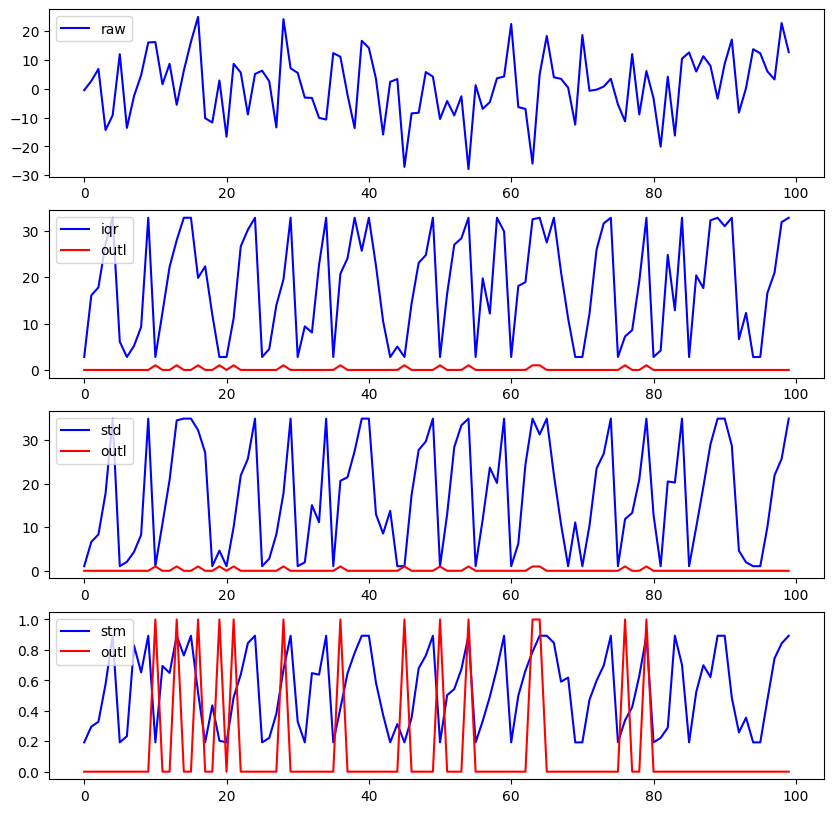

In [33]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
axs = axs.flatten()

axs[0].plot(dfa["A"], color="blue", label="raw")

axs[1].plot(diqr["A"], color="blue", label="iqr")
axs[1].plot(diqr["OUTL_FLAG"], color="red", label="outl")

axs[2].plot(dstd["A"], color="blue", label="std")
axs[2].plot(dstd["OUTL_FLAG"], color="red", label="outl")

axs[3].plot(dstm["A"], color="blue", label="stm")
axs[3].plot(dstm["OUTL_FLAG"], color="red", label="outl")

axs[0].legend(loc="upper left")
axs[1].legend(loc="upper left")
axs[2].legend(loc="upper left")
axs[3].legend(loc="upper left")

plt.legend(loc="upper left")
plt.show()

In [10]:
import random

# Sample list
my_list = [1, 2, 3, 4, 5]

# Select 3 random elements without replacement
x = random.sample(my_list, k=5)
x

[1, 2, 3, 5, 4]

In [11]:
x

[1, 2, 3, 5, 4]